Trying to develop a classifier that can discriminate between two classes:  `cars` and `bicycles`.          
        

## Loading a Pre-Trained Deep Network

I use the pre-trained deep VGG16 network.  

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import keras
keras.backend.clear_session()

Set the dimensions of the input image.  

In [ ]:

nrow = 64
ncol = 64

In [ ]:
input_shape = (nrow, ncol, 3)
base_model = applications.VGG16(weights = 'imagenet', input_shape = input_shape, include_top = False)

In [ ]:
# Create a new model
model = Sequential()

# Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
  model.add(layer)

Freezing each layer by setting `layer.trainable = False` will avoid us from having to *re-train* any of the existing layers.

In [ ]:
for layer in model.layers:
  layer.trainable = False

Layers:

* A `Flatten()` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 256 output units and `relu` activation
* A `Dropout(0.5)` layer.
* A final fully-connected layer.  Since this is a binary classification, there should be one output and `sigmoid` activation.

In [ ]:
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       2

## Using Generators to Load Data

The `ImageDataGenerator` class that can fetch images on the fly from a directory of images.  Using multi-threading, training can be performed on one mini-batch while the image reader can read files for the next mini-batch. 

In [ ]:
!unzip test.zip
!unzip train.zip

In [ ]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [ ]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

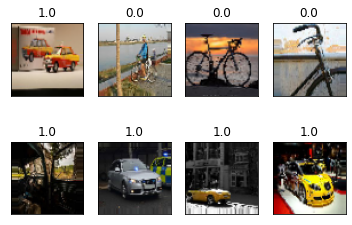

In [ ]:
# Display the first 8 images in this mini-batch and label the image with the class label.
X, y = train_generator.next()
nplot = 8
for i in range(nplot):
  plt.subplot(2, 4, i+1)
  disp_image(X[i])
  plt.title(y[i])
plt.show()

## Train the Model


In [ ]:
from tensorflow.python.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [ ]:
nepochs = 5  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
62/62 [==============================] - 6s 99ms/step - loss: 0.3922 - accuracy: 0.8227 - val_loss: 0.2327 - val_accuracy: 0.9028
Epoch 2/5
62/62 [==============================] - 6s 94ms/step - loss: 0.2972 - accuracy: 0.8704 - val_loss: 0.2030 - val_accuracy: 0.9132
Epoch 3/5
62/62 [==============================] - 6s 96ms/step - loss: 0.2550 - accuracy: 0.8897 - val_loss: 0.1783 - val_accuracy: 0.9253
Epoch 4/5
62/62 [==============================] - 6s 96ms/step - loss: 0.2439 - accuracy: 0.8968 - val_loss: 0.1528 - val_accuracy: 0.9479
Epoch 5/5
62/62 [==============================] - 6s 97ms/step - loss: 0.2110 - accuracy: 0.9162 - val_loss: 0.1904 - val_accuracy: 0.9219


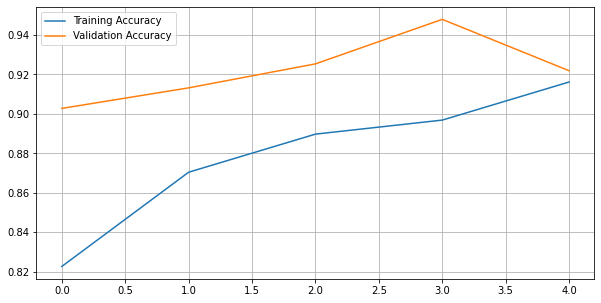

In [ ]:
# Plot the training accuracy and validation accuracy curves on the same figure.

train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize = (10, 5))
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend()
plt.grid()

## Plotting the Error Images



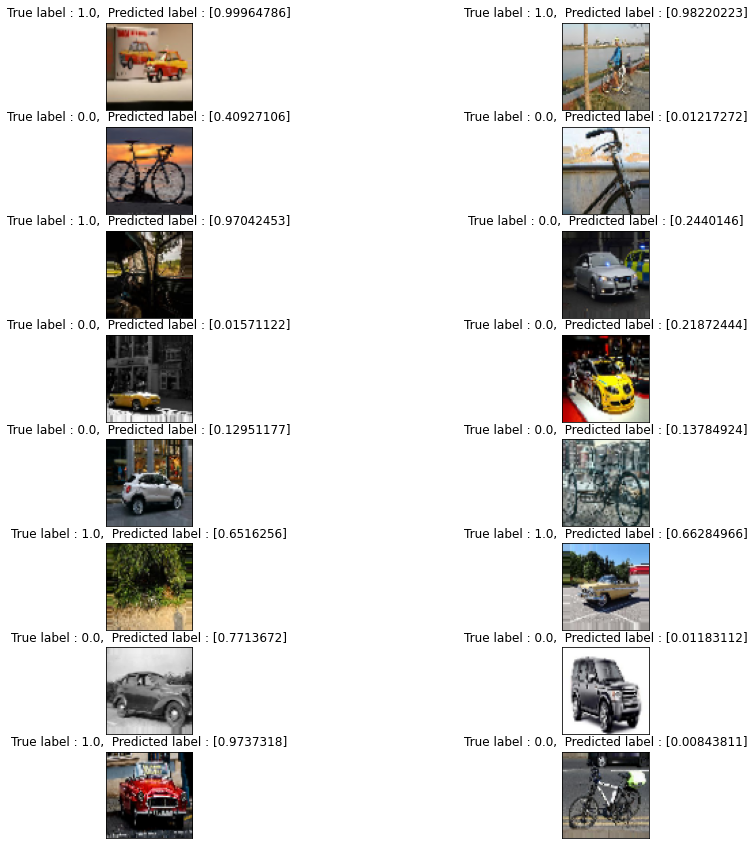

In [ ]:
Xts, yts = train_generator.next()
yhat = model.predict(Xts)
incorrect_imgs = yhat != yts

plt.figure(figsize = (15, 15))
for i in range(16):
  plt.subplot(8, 2, i + 1)
  disp_image(X[i])
  plt.title('True label : {},  Predicted label : {}'.format(yts[i], yhat[i]))